In [1]:
# wget https://raw.githubusercontent.com/Vaseekaran-V/Datastorm-3/main/data/train_data_modified.csv?token=GHSAT0AAAAAABS4N64JYNY6EXMSZROSSTSOYSJQHMQ
# !wget https://raw.githubusercontent.com/Vaseekaran-V/Datastorm-3/main/data/validation_data.csv?token=GHSAT0AAAAAABS4N64JIDICIDNZNGXSE2HGYSIQRIQ
# !wget https://raw.githubusercontent.com/Vaseekaran-V/Datastorm-3/main/data/test_data.csv?token=GHSAT0AAAAAABS4N64J3BGH5UCQAEMW3NK2YSIQR7A

## Import Libraries

In [1]:
def week_id_valid(week):
    if week=="w1":    return 1
    elif week=="w2":    return 2
    elif week=="w3": return 3
    else: return 4

In [2]:
from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error
def calculate_results(y_true, y_pred):
    return {'mae':mean_absolute_error(y_true, y_pred),
          'mape': mean_absolute_percentage_error(y_true, y_pred)}

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

In [4]:
train_data = pd.read_csv(r"../data/train_data_modified.csv")
train_data

,CategoryCode,ItemCode,Week,id,WeeklySales
0,category_2,174436,w1,1,35
1,category_2,118033,w1,1,7
2,category_2,20824,w1,1,53
3,category_1,1061341,w1,1,18
4,category_1,76399,w1,1,21
...,...,...,...,...,...
3767,category_1,1044619,w4,20,45
3768,category_4,23200,w4,20,22
3769,category_1,1084498,w4,20,7
3770,category_4,872260,w4,20,12


In [5]:
valid_data = pd.read_csv(r'../data/validation_data.csv')
valid_data['id'] = [week_id_valid(week)+20 for week in valid_data['Week']]
valid_data.sort_values(by='id', inplace = True)
valid_data

,CategoryCode,ItemCode,Week,WeeklySales,id
0,category_2,1044502,w1,11,21
142,category_1,48940,w1,22,21
269,category_1,35584,w1,15,21
138,category_2,59749,w1,33,21
137,category_2,132028,w1,112,21
...,...,...,...,...,...
139,category_2,118033,w4,12,24
140,category_2,1098502,w4,4,24
268,category_2,1010068,w4,19,24
146,category_2,211309,w4,23,24


In [6]:
test_data = pd.read_csv('../data/test_data.csv')
test_data['id'] = [week_id_valid(week)+20 for week in test_data['Week']]
test_data

,CategoryCode,ItemCode,Week,PredictedSales,id
0,category_1,43738,w4,NaN,24
1,category_2,1006090,w1,NaN,21
2,category_2,1076929,w4,NaN,24
3,category_1,1081321,w3,NaN,23
4,category_2,216151,w4,NaN,24
...,...,...,...,...,...
372,category_2,1101571,w1,NaN,21
373,category_2,1090258,w4,NaN,24
374,category_2,906595,w1,NaN,21
375,category_2,32245,w1,NaN,21


## Adding train and valid dataset together

In [7]:
train_valid = pd.concat([train_data, valid_data])
train_valid

,CategoryCode,ItemCode,Week,id,WeeklySales
0,category_2,174436,w1,1,35
1,category_2,118033,w1,1,7
2,category_2,20824,w1,1,53
3,category_1,1061341,w1,1,18
4,category_1,76399,w1,1,21
...,...,...,...,...,...
139,category_2,118033,w4,24,12
140,category_2,1098502,w4,24,4
268,category_2,1010068,w4,24,19
146,category_2,211309,w4,24,23


In [8]:
#train_valid.drop(["Week"], axis=1, inplace = True)

## Feature  Engineering

In [178]:
df = train_valid.copy()
train_test = train_data.copy()
test_df = test_data.copy()

test_df.columns = ['CategoryCode','ItemCode','Week','WeeklySales','id']
test_df

le = LabelEncoder()
le.fit(df['ItemCode'])

df['ItemCode_Label'] = le.transform(df['ItemCode'])
train_test['ItemCode_Label'] = le.transform(train_test['ItemCode'])
test_df['ItemCode_Label'] = le.transform(test_df['ItemCode'])

# df['Week'] = pd.DataFrame(le.fit_transform(df[["Week"]]).toarray())
# train_test['Week'] = pd.DataFrame(le.transform(train_test[['Week']]).toarray())
# test_df['Week'] = pd.DataFrame(le.transform(test_df[['Week']]).toarray())



# df.drop(['CategoryCode'], axis=1, inplace = True)
# train_test.drop(['CategoryCode'], axis = 1, inplace = True)
# test_df.drop(['CategoryCode'], axis = 1 , inplace = True)

In [179]:
df

,CategoryCode,ItemCode,Week,id,WeeklySales,ItemCode_Label
0,category_2,174436,w1,1,35,64
1,category_2,118033,w1,1,7,47
2,category_2,20824,w1,1,53,7
3,category_1,1061341,w1,1,18,141
4,category_1,76399,w1,1,21,36
...,...,...,...,...,...,...
139,category_2,118033,w4,24,12,47
140,category_2,1098502,w4,24,4,184
268,category_2,1010068,w4,24,19,113
146,category_2,211309,w4,24,23,66


In [102]:
# from sklearn.preprocessing import OneHotEncoder
# cat_cols = ['Week', 'CategoryCode']

# onehot = OneHotEncoder()
# onehot_df = pd.DataFrame(onehot.fit_transform(df[cat_cols]).toarray())
# onehot_df.columns = ['w'+str(i) for i in range(1,5)] + ['cat'+str(i) for i in range(1,5)]
# onehot_df
# df = pd.concat([df.reset_index().drop(["index"], axis=1), onehot_df], axis = 1)
# df.drop(['Week'], axis = 1, inplace = True)

In [103]:
df

,CategoryCode,ItemCode,id,WeeklySales,ItemCode_Label,w1,w2,w3,w4,cat1,cat2,cat3,cat4
0,category_2,174436,1,35,64,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,category_2,118033,1,7,47,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,category_2,20824,1,53,7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,category_1,1061341,1,18,141,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,category_1,76399,1,21,36,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137,category_2,118033,24,12,47,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4138,category_2,1098502,24,4,184,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4139,category_2,1010068,24,19,113,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4140,category_2,211309,24,23,66,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [104]:
# onehot_df = pd.DataFrame(onehot.transform(train_test[cat_cols]).toarray())
# onehot_df.columns = ['w'+str(i) for i in range(1,5)] + ['cat'+str(i) for i in range(1,5)]
# onehot_df
# train_test = pd.concat([train_test, onehot_df], axis = 1)
# train_test

,CategoryCode,ItemCode,Week,id,WeeklySales,ItemCode_Label,w1,w2,w3,w4,cat1,cat2,cat3,cat4
0,category_2,174436,w1,1,35,64,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,category_2,118033,w1,1,7,47,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,category_2,20824,w1,1,53,7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,category_1,1061341,w1,1,18,141,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,category_1,76399,w1,1,21,36,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,category_1,1044619,w4,20,45,128,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3768,category_4,23200,w4,20,22,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3769,category_1,1084498,w4,20,7,170,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3770,category_4,872260,w4,20,12,97,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [105]:
# onehot_df = pd.DataFrame(onehot.transform(test_df[cat_cols]).toarray())
# onehot_df.columns = ['w'+str(i) for i in range(1,5)] + ['cat'+str(i) for i in range(1,5)]
# onehot_df
# test_df = pd.concat([test_df, onehot_df], axis = 1)
# test_df

,CategoryCode,ItemCode,Week,WeeklySales,id,ItemCode_Label,w1,w2,w3,w4,cat1,cat2,cat3,cat4
0,category_1,43738,w4,NaN,24,27,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,category_2,1006090,w1,NaN,21,110,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,category_2,1076929,w4,NaN,24,160,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,category_1,1081321,w3,NaN,23,167,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,category_2,216151,w4,NaN,24,68,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,category_2,1101571,w1,NaN,21,187,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
373,category_2,1090258,w4,NaN,24,177,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
374,category_2,906595,w1,NaN,21,102,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
375,category_2,32245,w1,NaN,21,12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [155]:
df

,CategoryCode,ItemCode,Week,id,WeeklySales,ItemCode_Label
0,category_2,174436,w1,1,35,64
1,category_2,118033,w1,1,7,47
2,category_2,20824,w1,1,53,7
3,category_1,1061341,w1,1,18,141
4,category_1,76399,w1,1,21,36
...,...,...,...,...,...,...
139,category_2,118033,w4,24,12,47
140,category_2,1098502,w4,24,4,184
268,category_2,1010068,w4,24,19,113
146,category_2,211309,w4,24,23,66


In [156]:
df.groupby(['ItemCode'])['WeeklySales'].mean()

ItemCode
3418       64.625000
3427       42.416667
7666       76.260870
9925       11.900000
16936      45.150000
             ...    
1101769    14.800000
1103056    16.333333
1105009     8.619048
1105018     7.687500
1105027     9.562500
Name: WeeklySales, Length: 194, dtype: float64

In [180]:
def get_quan_cat_columns(dataframe):
    '''
    Used to extract and separate the categorical and quantitative columns in the datafram
    Input -> a dataframe with named columns
    Output -> 2 outputs: a list of quantitative columns and a list of categorical columns
    '''
    quan_cols = []
    cat_cols = []
    
    for column in dataframe.columns:
        if(dataframe[column].dtype == 'float' or dataframe[column].dtype == 'int'):
            quan_cols.append(column)
        elif (dataframe[column].dtype == 'object'):
            cat_cols.append(column)
            
    return quan_cols, cat_cols

In [181]:
def add_features(dataframe):
    Average_Sales = dataframe.groupby(['ItemCode'])['WeeklySales'].mean().to_frame('AverageSales').reset_index()
    dataframe = pd.merge(dataframe, Average_Sales, on = 'ItemCode')
    dataframe['Last_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift()
    dataframe['Last_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(periods=1) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(periods=2)
    dataframe['Last-1_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(2)
    dataframe['Last-1_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(periods=1) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(periods=3)
    dataframe['Last-2_Week_Sales'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(3)
    dataframe['Last-2_Week_Diff'] = dataframe.groupby(['ItemCode'])['WeeklySales'].shift(periods=1) - dataframe.groupby(['ItemCode'])['WeeklySales'].shift(periods=4)
    
    return dataframe

In [182]:
df = add_features(df)
df = df.dropna()
df.head()

,CategoryCode,ItemCode,Week,id,WeeklySales,ItemCode_Label,AverageSales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
4,category_2,174436,w1,5,85,64,56.15,69.0,9.0,60.0,5.0,64.0,34.0
5,category_2,174436,w2,6,62,64,56.15,85.0,16.0,69.0,25.0,60.0,21.0
6,category_2,174436,w3,7,73,64,56.15,62.0,-23.0,85.0,-7.0,69.0,2.0
7,category_2,174436,w4,8,47,64,56.15,73.0,11.0,62.0,-12.0,85.0,4.0
8,category_2,174436,w1,9,90,64,56.15,47.0,-26.0,73.0,-15.0,62.0,-38.0


In [183]:
train_test_copy = train_test.copy()

In [184]:
from lightgbm import LGBMRegressor

In [185]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [186]:
def hp_tuning(model, param_grid, train_x, train_y, cv = 5, scoring = 'neg_mean_absolute_error'):
    clf = GridSearchCV(model, param_grid, cv=cv, scoring=scoring)
    clf.fit(train_x, train_y)
    return clf.best_params_

In [187]:
def drop_columns(dataframe, columns_to_drop):
    for column in columns_to_drop:
        if column in dataframe.columns:
            dataframe = dataframe.drop([column], axis = 1)
            
    return dataframe

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 4 to 4141
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CategoryCode       3366 non-null   object 
 1   ItemCode           3366 non-null   int64  
 2   Week               3366 non-null   object 
 3   id                 3366 non-null   int64  
 4   WeeklySales        3366 non-null   int64  
 5   ItemCode_Label     3366 non-null   int64  
 6   AverageSales       3366 non-null   float64
 7   Last_Week_Sales    3366 non-null   float64
 8   Last_Week_Diff     3366 non-null   float64
 9   Last-1_Week_Sales  3366 non-null   float64
 10  Last-1_Week_Diff   3366 non-null   float64
 11  Last-2_Week_Sales  3366 non-null   float64
 12  Last-2_Week_Diff   3366 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage: 368.2+ KB


In [189]:
c  = []
mean_error = []
columns_to_drop = ['WeeklySales', 'ItemCode']
for week in range(21,25):

    train = df[df['id'] < week]
    val = df[df['id'] == week]

    xtr, xts = drop_columns(train, columns_to_drop), drop_columns(val, columns_to_drop)
    ytr, yts = train['WeeklySales'].values, val['WeeklySales'].values
    xtr = xtr.reindex(sorted(xtr.columns), axis=1)
    xts = xts.reindex(sorted(xts.columns), axis=1)
    
    xtr_quan, xtr_cat = get_quan_cat_columns(xtr)
    xts_quan, xts_cat = get_quan_cat_columns(xts)
    
    quan_pipeline = Pipeline([('std_scaler', StandardScaler())])
    quan_transformed = quan_pipeline.fit_transform(xtr[xtr_quan])
    
    data_pipeline = ColumnTransformer([('numerical', quan_pipeline, xtr_quan),
                                       ('categorical', OneHotEncoder(handle_unknown = 'ignore'), xtr_cat),])

    xtr_sc = data_pipeline.fit_transform(xtr)
    xts_sc = data_pipeline.transform(xts)
    
    #Hp tuning
    param_grid = {'n_estimators': [400, 450, 500], 'learning_rate': [0.01, 0.02, 0.03, 0.04]}
    best_params = hp_tuning(model = XGBRegressor(), param_grid = param_grid, train_x = xtr_sc, train_y = np.log1p(ytr))
    print(best_params)

    mdl = XGBRegressor(n_estimators = best_params['n_estimators'], learning_rate = best_params['learning_rate'])
    mdl.fit(xtr_sc, np.log1p(ytr))
    p = np.expm1(mdl.predict(xts_sc)) # on validation

    error = calculate_results(yts, p)
    print(f'Week {week} - Error {error}')
    mean_error.append(error)

    train_test = pd.concat([train_test, test_df[test_df['id']==week]])
    train_test = add_features(train_test)
    
    # train_test = df.dropna()

    train = train_test[train_test['id'] < week]
    train = train.dropna()
    test = train_test[train_test['id']==week]

    xtest = drop_columns(test, columns_to_drop)
    ytest = test['WeeklySales'].values
    
    xtest = xtest.reindex(sorted(xtest.columns), axis=1)
    
    xtest_sc = data_pipeline.transform(xtest)

    test_p = np.expm1(mdl.predict(xtest_sc)) # test data
    # test_df[test_df['id']==week]['WeeklySales'] = test_p
    train_test.drop(['AverageSales'], axis = 1, inplace = True)

    c.append({'CategoryCode': test['CategoryCode'],'ItemCode':test['ItemCode'], 'Week':test['Week'],'id':test['id'] ,'WeeklySales':test_p})

# print('Mean Error = %.5f' % np.mean(mean_error))

{'learning_rate': 0.01, 'n_estimators': 500}
Week 21 - Error {'mae': 10.848504401825286, 'mape': 0.5891679922873734}
{'learning_rate': 0.02, 'n_estimators': 400}
Week 22 - Error {'mae': 16.33920547754868, 'mape': 0.48240657536333365}
{'learning_rate': 0.02, 'n_estimators': 400}
Week 23 - Error {'mae': 19.599968067977738, 'mape': 0.6971422111000606}
{'learning_rate': 0.02, 'n_estimators': 400}
Week 24 - Error {'mae': 19.75787915179604, 'mape': 0.46234060082299266}


In [121]:
xts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 43 to 4141
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AverageSales       95 non-null     float64
 1   ItemCode_Label     95 non-null     int64  
 2   Last-1_Week_Sales  95 non-null     float64
 3   Last-2_Week_Diff   95 non-null     float64
 4   Last-2_Week_Sales  95 non-null     float64
 5   Last_Week_Diff     95 non-null     float64
 6   Last_Week_Sales    95 non-null     float64
 7   cat1               95 non-null     float64
 8   cat2               95 non-null     float64
 9   cat3               95 non-null     float64
 10  w2                 95 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 8.9 KB


In [118]:
xtr.columns

Index(['AverageSales', 'ItemCode_Label', 'Last-1_Week_Sales',
       'Last-2_Week_Diff', 'Last-2_Week_Sales', 'Last_Week_Diff',
       'Last_Week_Sales', 'cat1', 'cat2', 'cat3', 'w2'],
      dtype='object')

Text(0.5, 1.0, 'Feature Importance')

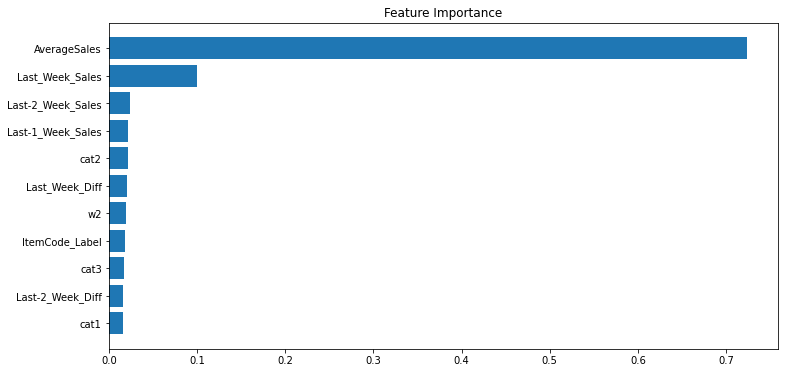

In [119]:
# **Feature Importance**
feature_importance = mdl.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(xtr.columns)[sorted_idx])
plt.title('Feature Importance')

In [237]:
train_test

,CategoryCode,ItemCode,Week,id,WeeklySales,w1,w2,w3,w4,cat1,cat2,cat3,cat4,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
0,category_2,174436,w1,1,35.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,category_2,174436,w2,2,64.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,35.0,NaN,NaN,NaN,NaN,NaN
2,category_2,174436,w3,3,60.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,64.0,29.0,35.0,NaN,NaN,NaN
3,category_2,174436,w4,4,69.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,60.0,-4.0,64.0,25.0,35.0,NaN
4,category_2,174436,w1,5,85.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,69.0,9.0,60.0,5.0,64.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,category_2,267496,w4,16,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,10.0,2.0,8.0,1.0,9.0,0.0
4145,category_2,267496,w1,17,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0,10.0,2.0,8.0,1.0
4146,category_2,267496,w2,18,11.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0,10.0,0.0,10.0,2.0
4147,category_2,267496,w3,19,15.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,11.0,1.0,10.0,1.0,10.0,1.0


In [238]:
mape = []
for error in mean_error:
    mape.append(error['mape'])
mape

[0.595098697029495, 0.4949737883309334, 0.6968826132241487, 0.4556767924430322]

In [239]:
pd.DataFrame(c[1])

,CategoryCode,ItemCode,Week,id,WeeklySales
21,category_2,174436,w2,22,19.847765
82,category_1,1061341,w2,22,12.264301
183,category_1,1054978,w2,22,18.775116
242,category_3,1060630,w2,22,8.009307
264,category_1,36898,w2,22,22.003401
...,...,...,...,...,...
3836,category_1,1075651,w2,22,7.107069
3872,category_3,893824,w2,22,15.701453
3892,category_2,1103056,w2,22,9.484501
3927,category_2,1105018,w2,22,5.971674


In [240]:
submissions = test_data.drop(['PredictedSales'], axis = 1)
submissions

,CategoryCode,ItemCode,Week,id
0,category_1,43738,w4,24
1,category_2,1006090,w1,21
2,category_2,1076929,w4,24
3,category_1,1081321,w3,23
4,category_2,216151,w4,24
...,...,...,...,...
372,category_2,1101571,w1,21
373,category_2,1090258,w4,24
374,category_2,906595,w1,21
375,category_2,32245,w1,21


In [241]:
all_concat = pd.concat([pd.DataFrame(c[0]), pd.DataFrame(c[1]),pd.DataFrame(c[2]),pd.DataFrame(c[3])])
all_concat

,CategoryCode,ItemCode,Week,id,WeeklySales
20,category_2,174436,w1,21,52.588448
80,category_1,1061341,w1,21,17.440523
180,category_1,1054978,w1,21,51.795860
238,category_3,1060630,w1,21,25.261890
259,category_1,36898,w1,21,81.107124
...,...,...,...,...,...
4016,category_1,1075651,w4,24,6.421178
4054,category_3,893824,w4,24,14.163766
4076,category_2,1103056,w4,24,5.113579
4113,category_2,1105018,w4,24,4.031205


In [242]:
submissions1 = pd.merge(submissions,all_concat, on=["CategoryCode","ItemCode","Week","id"], how = "left")
submissions1

,CategoryCode,ItemCode,Week,id,WeeklySales
0,category_1,43738,w4,24,7.643266
1,category_2,1006090,w1,21,16.990141
2,category_2,1076929,w4,24,4.421385
3,category_1,1081321,w3,23,8.839291
4,category_2,216151,w4,24,5.113579
...,...,...,...,...,...
372,category_2,1101571,w1,21,13.857775
373,category_2,1090258,w4,24,9.026753
374,category_2,906595,w1,21,8.945224
375,category_2,32245,w1,21,41.475243


In [243]:
submissions1['ID'] = [str(category)+'_'+str(item)+'_'+str(week) for category,item,week in zip(submissions1['CategoryCode'], submissions1['ItemCode'],submissions1['Week'])]
submissions1['ID']

0        category_1_43738_w4
1      category_2_1006090_w1
2      category_2_1076929_w4
3      category_1_1081321_w3
4       category_2_216151_w4
               ...          
372    category_2_1101571_w1
373    category_2_1090258_w4
374     category_2_906595_w1
375      category_2_32245_w1
376    category_2_1006090_w2
Name: ID, Length: 377, dtype: object

In [244]:
submissions1[['ID','WeeklySales']].to_csv("submissions_5_xgb.csv", index = False)

In [245]:
submissions0 = pd.read_csv(r'../submissions/submission_0_naive_forecast_with_average (7).csv')
submissions0

,ID,WeeklySales
0,category_2_87559_w1,24.300000
1,category_2_9925_w1,11.900000
2,category_2_999403_w1,15.150000
3,category_2_1103056_w1,16.333333
4,category_2_838456_w1,15.850000
...,...,...
372,category_2_87559_w4,24.300000
373,category_3_37861_w4,135.450000
374,category_1_1067119_w4,25.400000
375,category_1_839374_w4,40.200000


In [246]:
submission_third = pd.read_csv(r'../submissions/submissions_3.csv')

In [247]:
pd.merge(submissions0[['ID','WeeklySales']], submissions1[['ID','WeeklySales']] , on = ['ID'])

,ID,WeeklySales_x,WeeklySales_y
0,category_2_87559_w1,24.300000,26.074680
1,category_2_9925_w1,11.900000,11.765001
2,category_2_999403_w1,15.150000,12.237195
3,category_2_1103056_w1,16.333333,12.683940
4,category_2_838456_w1,15.850000,14.985248
...,...,...,...
372,category_2_87559_w4,24.300000,9.026753
373,category_3_37861_w4,135.450000,22.188583
374,category_1_1067119_w4,25.400000,10.696761
375,category_1_839374_w4,40.200000,15.661566


In [248]:
pd.merge(submission_third[['ID','WeeklySales']], submissions1[['ID','WeeklySales']] , on = ['ID'])

,ID,WeeklySales_x,WeeklySales_y
0,category_1_43738_w4,8.425899,7.643266
1,category_2_1006090_w1,12.783702,16.990141
2,category_2_1076929_w4,8.122628,4.421385
3,category_1_1081321_w3,10.551371,8.839291
4,category_2_216151_w4,5.928541,5.113579
...,...,...,...
372,category_2_1101571_w1,9.276697,13.857775
373,category_2_1090258_w4,14.287120,9.026753
374,category_2_906595_w1,9.173033,8.945224
375,category_2_32245_w1,53.779427,41.475243


In [299]:
submissions1

,CategoryCode,ItemCode,Week,id,WeeklySales,ID
0,category_1,43738,w4,24,17.712546,category_1_43738_w4
1,category_2,1006090,w1,21,12.570432,category_2_1006090_w1
2,category_2,1076929,w4,24,4.854171,category_2_1076929_w4
3,category_1,1081321,w3,23,5.450139,category_1_1081321_w3
4,category_2,216151,w4,24,11.005400,category_2_216151_w4
...,...,...,...,...,...,...
372,category_2,1101571,w1,21,12.927856,category_2_1101571_w1
373,category_2,1090258,w4,24,5.895047,category_2_1090258_w4
374,category_2,906595,w1,21,9.623596,category_2_906595_w1
375,category_2,32245,w1,21,40.117116,category_2_32245_w1
